#Data info

Roasted coffee beans have been roasted at JJ Mall Jatujak’s, “Bona Coffee.” There are four roasting levels. The **green or un-roasted** coffee beans are Laos Typica Bolaven (Coffea arabica). Laos Typica Bolaven is a **lightly** roasted coffee bean (Coffea arabica). Doi Chaang (Coffea Arabica) is **medium** roasted, whereas Brazil Cerrado is **dark** roasted (Coffea Arabica). The coffee bean photos are captured with an IPhone12Mini with a 12-megapixel back camera, Ultra-wide, and WideCamera. The camera is set at a location with a plane parallel to the object’s path when photographs are being captured. Images of roasted coffee beans are captured in a variety of settings to validate a wide range of roasted coffee bean image inputs. This experiment employs both LED light from a light box and natural light to shoot the dataset; then the image’s noise is enhanced by putting each variety of coffee beans in a container. Images are automatically collected and saved in PNG format. 

#Loading and exploring dataset

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from zipfile import ZipFile
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D 
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback

from tensorflow.keras.applications import ResNet50V2, EfficientNetV2B0

import warnings
warnings.filterwarnings('ignore')


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/GIT_AI/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/GIT_AI


In [3]:
archive = ZipFile('DATA/coffee.zip', 'r')

In [ ]:
archive.namelist()[:10]

['Coffee Bean.csv',
 'test/Dark/',
 'test/Dark/dark (1).png',
 'test/Dark/dark (10).png',
 'test/Dark/dark (100).png',
 'test/Dark/dark (11).png',
 'test/Dark/dark (12).png',
 'test/Dark/dark (13).png',
 'test/Dark/dark (14).png',
 'test/Dark/dark (15).png']

In [ ]:
len(archive.namelist())

1609

In [ ]:
files = list(filter(lambda f: f.endswith("/"), archive.namelist()))
#files = [x for x in archive.namelist() if x.endswith('/')]
print(files)

['test/Dark/', 'test/Green/', 'test/Light/', 'test/Medium/', 'train/Dark/', 'train/Green/', 'train/Light/', 'train/Medium/']


In [ ]:
sample_img = imread(archive.open('train/Green/green (83).png'))

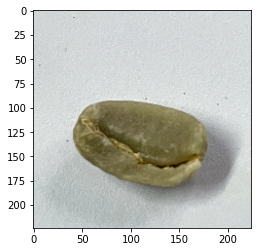

In [ ]:
plt.imshow(sample_img)

In [ ]:
sample_img.shape

(224, 224, 3)

In [ ]:
sample_img.max()

0.9647059

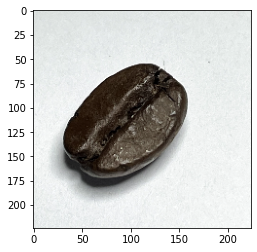

In [ ]:
 sample_img_2 = imread(archive.open('train/Dark/dark (188).png'))
 plt.imshow(sample_img_2)

In [ ]:
sample_img_2.shape

(224, 224, 3)

In [ ]:
sample_img_2.max()

1.0

In [ ]:
sample_img_2.min()

0.0

**Images are the same size and normalized.**

In [ ]:
len([x for x in archive.namelist() if x.startswith('test/') & x.endswith('png')])

400

In [ ]:
train_dir = list(filter(lambda x: 'train/' in x, archive.namelist()))
train_names = list(filter(lambda x: 'png' in x, train_dir))
len(train_names)

1200

In [ ]:
classes = ['train/Dark/', 'train/Green/', 'train/Light/', 'train/Medium/']
for c in classes:
  print(c+':', len([x for x in archive.namelist() if x.startswith(c) & x.endswith('png')]))

train/Dark/: 300
train/Green/: 300
train/Light/: 300
train/Medium/: 300


**This training set is balanced.**

#Dimension reduction - PCA

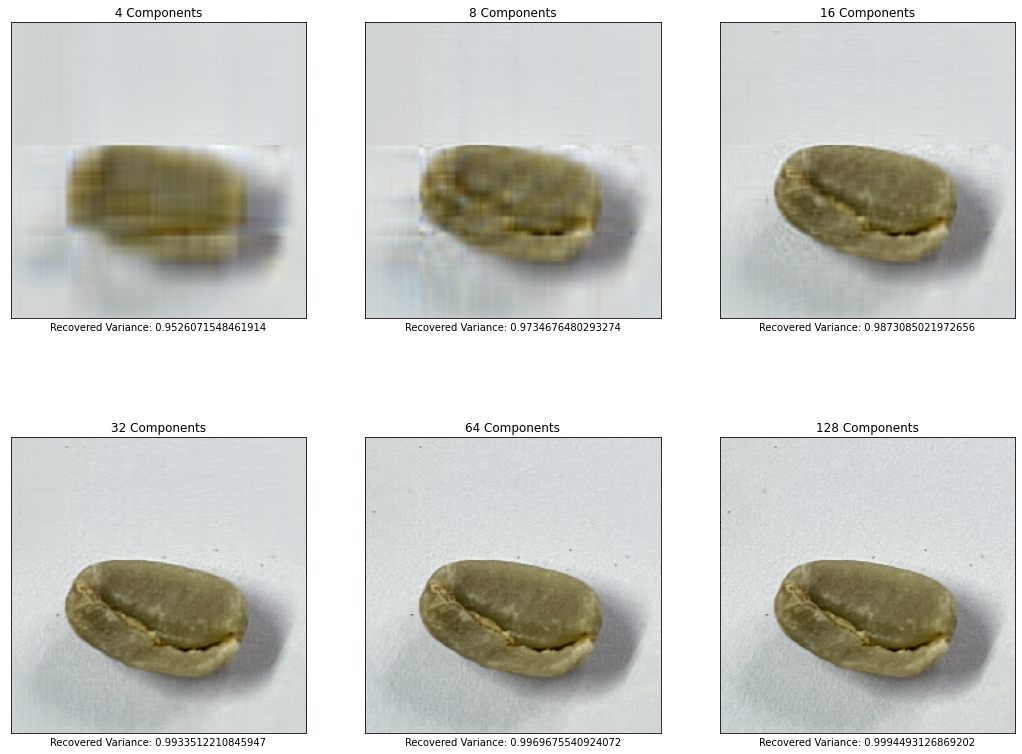

In [ ]:
component_num = [4, 8, 16, 32, 64, 128]
fig = plt.figure(figsize=(18, 14))
i = 0

for k in component_num:

  img_reduced = np.empty((224, 224, 3))

  for color in range(0,3):

    pca = PCA(k)
    fit_pca = pca.fit(sample_img[:, :, color])
    img_pca = fit_pca.transform(sample_img[:, :, color])  
    img_inv = pca.inverse_transform(img_pca)
    img_reduced[:, :, color] = img_inv

  ax = fig.add_subplot(2, 3, i + 1, xticks=[], yticks=[])
  ax.imshow(img_reduced)
  ax.set_title(f"{k} Components")
  ax.set_xlabel(f"Recovered Variance: {np.sum(pca.explained_variance_ratio_)}")
  i = i + 1
  img_reduced = []

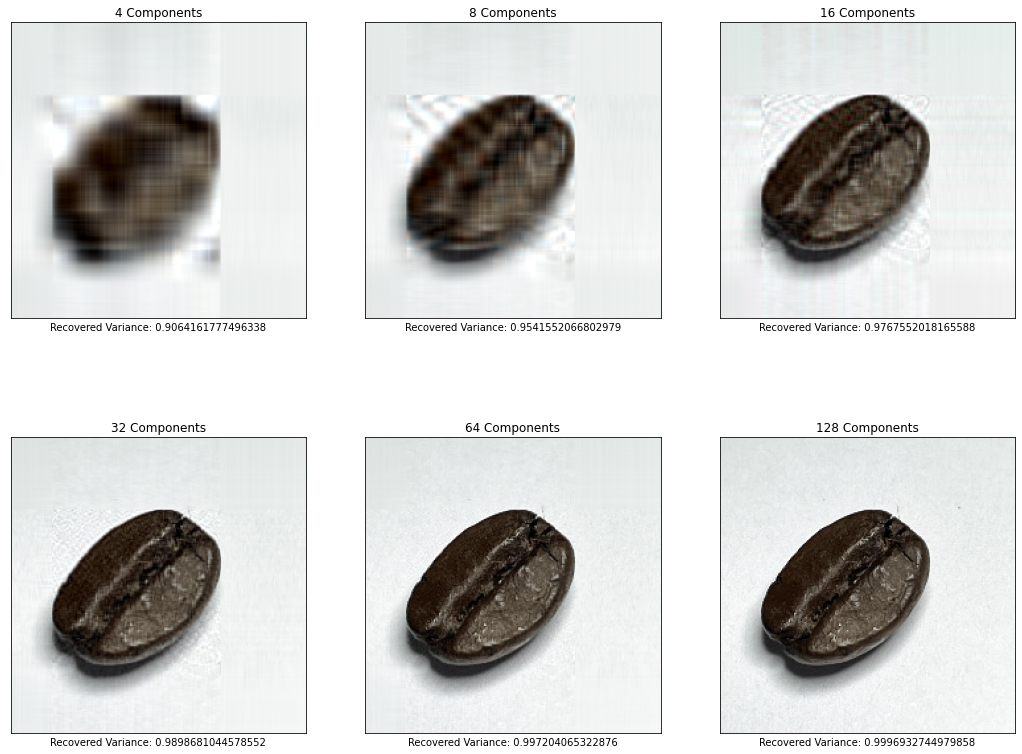

In [ ]:
component_num = [4, 8, 16, 32, 64, 128]
fig = plt.figure(figsize=(18, 14))
i = 0

for k in component_num:

  img_reduced = np.empty((224, 224, 3))

  for color in range(0,3):

    pca = PCA(k)
    fit_pca = pca.fit(sample_img_2[:, :, color])
    img_pca = fit_pca.transform(sample_img_2[:, :, color])  
    img_inv = pca.inverse_transform(img_pca)
    img_reduced[:, :, color] = img_inv

  ax = fig.add_subplot(2, 3, i + 1, xticks=[], yticks=[])
  ax.imshow(img_reduced)
  ax.set_title(f"{k} Components")
  ax.set_xlabel(f"Recovered Variance: {np.sum(pca.explained_variance_ratio_)}")
  i = i + 1
  img_reduced = []

**It is worth to checking models' performance on reduced images using 4 and 32 components.**

In [4]:
# 4 components
X_train_pca4 = np.empty((1200, 224, 224, 3))
X_test_pca4 = np.empty((400, 224, 224, 3))
i = 0
y = 0
pca = PCA(4)
for file in archive.namelist():
  img_reduced = np.empty((224, 224, 3))
  try:
    if not file.endswith('.png'):
      continue 
    img = imread(archive.open(file)) 
    for color in range(0,3):  
      img_pca = pca.fit(img[:, :, color]).transform(img[:, :, color]) 
      img_inv = pca.inverse_transform(img_pca)
      img_reduced[:, :, color] = img_inv
    if file.startswith('test/') & file.endswith('.png'):
      X_test_pca4[i] = img_reduced
      i += 1
    else:
      X_train_pca4[y] = img_reduced
      y += 1            
  except:
    pass   

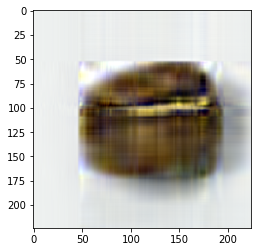

In [5]:
plt.imshow(X_test_pca4[399])

In [6]:
# 32 components
X_train_pca32 = np.empty((1200, 224, 224, 3))
X_test_pca32 = np.empty((400, 224, 224, 3))
i = 0
y = 0
pca = PCA(32)
for file in archive.namelist():
  img_reduced = np.empty((224, 224, 3))
  try:
    if not file.endswith('.png'):
      continue 
    img = imread(archive.open(file)) 
    for color in range(0,3):  
      img_pca = pca.fit(img[:, :, color]).transform(img[:, :, color]) 
      img_inv = pca.inverse_transform(img_pca)
      img_reduced[:, :, color] = img_inv
    if file.startswith('test/') & file.endswith('.png'):
      X_test_pca32[i] = img_reduced
      i += 1
    else:
      X_train_pca32[y] = img_reduced
      y += 1            
  except:
    pass  
archive.close()

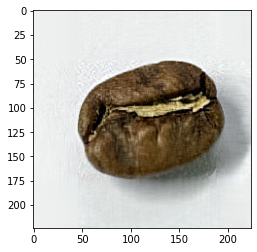

In [7]:
plt.imshow(X_test_pca32[399])

In [8]:
# labels encoding
y_train = []
y_test = []
i = 0
y = 0
for file in archive.namelist():
  if not file.endswith('.png'):
    continue 
  if file.startswith('test/') & file.endswith('.png'):
    y_test.append(file.split('/')[1])
  else:
    y_train.append(file.split('/')[1])

In [9]:
np.unique(y_train)

array(['Dark', 'Green', 'Light', 'Medium'], dtype='<U6')

In [10]:
labels_enc = {v: n for n, v in enumerate(np.unique(y_train))}
print(labels_enc)

{'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}


In [11]:
y_train = pd.Series(y_train).map(labels_enc)
y_test = pd.Series(y_test).map(labels_enc)

In [12]:
y_cat_train = to_categorical(y_train, 4)
y_cat_test = to_categorical(y_test, 4)

#Data augmentation

**Generating slightly different images with the same size for better model predictions of new instances.**

In [13]:
imagegen = ImageDataGenerator(rotation_range=30, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 10%
                               height_shift_range=0.10, # Shift the pic height by a max of 10%
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                               )
imagegen_test = ImageDataGenerator()

In [14]:
batch_size = 32 

In [15]:
train_imagegen_pca4 = imagegen.flow(X_train_pca4, y_cat_train, batch_size=batch_size, seed=2022)
test_imagegen_pca4 = imagegen_test.flow(X_test_pca4, y_cat_test, batch_size=batch_size, seed=2022, shuffle=False)

In [16]:
train_imagegen_pca32 = imagegen.flow(X_train_pca32, y_cat_train, batch_size=batch_size, seed=2022)
test_imagegen_pca32 = imagegen_test.flow(X_test_pca32, y_cat_test, batch_size=batch_size, seed=2022, shuffle=False)

#Models

##Custom model with images reconstructed with 4 principal components

In [17]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(4, 4), input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(1, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 1), input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 221, 221, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 52, 64)        6208      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 26, 64)      

In [49]:
early_stop = EarlyStopping(monitor='val_loss', patience=1)

In [50]:
results = model.fit_generator(train_imagegen_pca4, epochs=20,
                              validation_data=test_imagegen_pca4,
                              callbacks=[early_stop])

Epoch 1/20
38/38 [==============================] - 83s 2s/step - loss: 0.1565 - accuracy: 0.9358 - val_loss: 0.1869 - val_accuracy: 0.9400
Epoch 2/20
38/38 [==============================] - 80s 2s/step - loss: 0.1471 - accuracy: 0.9467 - val_loss: 0.0700 - val_accuracy: 0.9700
Epoch 3/20
38/38 [==============================] - 82s 2s/step - loss: 0.1146 - accuracy: 0.9592 - val_loss: 0.0732 - val_accuracy: 0.9750


In [ ]:
# from tensorflow.keras.models import load_model
# model.save('pca4_coffee_detector.h5')
# # model = load_model('....h5')
# hist_json_file = 'pca4_coffee_detector_history.json' 
# with open(hist_json_file, mode='w') as f:
#      pd.DataFrame(model.history.history).to_json(f)

In [54]:
losses = pd.DataFrame(model.history.history)

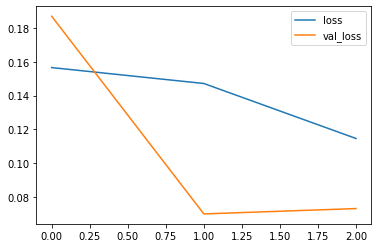

In [55]:
losses[['loss','val_loss']].plot()

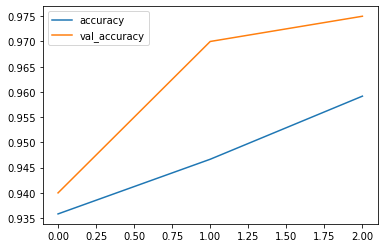

In [56]:
losses[['accuracy','val_accuracy']].plot()

In [64]:
model.evaluate(test_imagegen_pca4)

13/13 [==============================] - 6s 426ms/step - loss: 0.0732 - accuracy: 0.9750


[0.07320033013820648, 0.9750000238418579]

In [58]:
predictions = np.argmax(model.predict(test_imagegen_pca4), axis=-1)

In [60]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       100
           1       0.99      1.00      1.00       100
           2       0.98      1.00      0.99       100
           3       0.95      0.95      0.95       100

    accuracy                           0.97       400
   macro avg       0.97      0.98      0.97       400
weighted avg       0.97      0.97      0.97       400



In [62]:
cf = confusion_matrix(y_test, predictions)

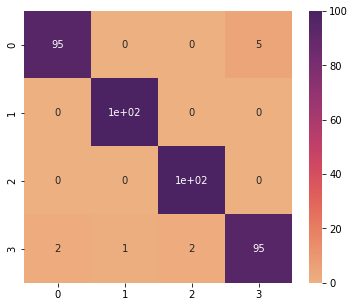

In [63]:
plt.figure(figsize=(6, 5))
sns.heatmap(cf, cmap="flare", annot=True)

##Custom model with images reconstructed with 32 principal components

In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=1)

In [23]:
results = model.fit(train_imagegen_pca32, epochs=20,
                              validation_data=test_imagegen_pca32,
                              callbacks=[early_stop])

Epoch 1/20
38/38 [==============================] - 92s 2s/step - loss: 0.1598 - accuracy: 0.9467 - val_loss: 0.1680 - val_accuracy: 0.9475
Epoch 2/20
38/38 [==============================] - 100s 3s/step - loss: 0.1718 - accuracy: 0.9408 - val_loss: 0.0760 - val_accuracy: 0.9700
Epoch 3/20
38/38 [==============================] - 101s 3s/step - loss: 0.2045 - accuracy: 0.9250 - val_loss: 0.1388 - val_accuracy: 0.9475


In [ ]:
# from tensorflow.keras.models import load_model
# model.save('pca32_coffee_detector.h5')
# # model = load_model('....h5')
# hist_json_file = 'pca32_coffee_detector_history.json' 
# with open(hist_json_file, mode='w') as f:
#      pd.DataFrame(model.history.history).to_json(f)

In [24]:
losses = pd.DataFrame(model.history.history)

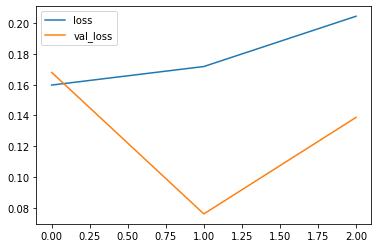

In [25]:
losses[['loss','val_loss']].plot()

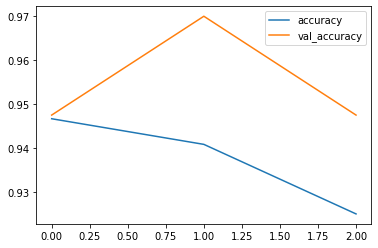

In [26]:
losses[['accuracy','val_accuracy']].plot()

In [31]:
model.evaluate(test_imagegen_pca32)

13/13 [==============================] - 5s 412ms/step - loss: 0.1388 - accuracy: 0.9475


[0.1387503743171692, 0.9474999904632568]

In [27]:
predictions = np.argmax(model.predict(test_imagegen_pca32), axis=-1)

In [28]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       100
           1       1.00      0.99      0.99       100
           2       0.89      1.00      0.94       100
           3       0.92      0.88      0.90       100

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



In [29]:
cf = confusion_matrix(y_test, predictions)

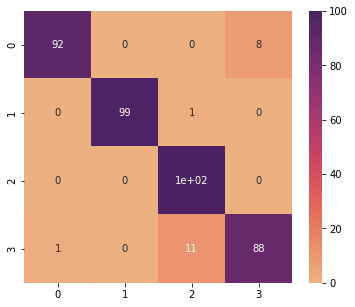

In [30]:
plt.figure(figsize=(6, 5))
sns.heatmap(cf, cmap="flare", annot=True)

##Transfer learning for images reconstructed with 32 principal components

In [43]:
class MyThresholdCallback(Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        acc = logs["accuracy"]
        if (val_acc >= self.threshold) & (acc >= self.threshold):
            self.model.stop_training = True

my_callback = MyThresholdCallback(threshold=0.9)

###ResNet 

In [44]:
#tf.keras.applications.resnet_v2.preprocess_input
base_model = ResNet50V2(include_top=False, weights="imagenet")

base_model.trainable = False

inputs = Input(shape=(224,224,3))
 
x = base_model(inputs)

x = GlobalAveragePooling2D()(x)

outputs = Dense(4, activation="softmax")(x)

model_rn = Model(inputs, outputs)

model_rn.compile(loss = "categorical_crossentropy",
                optimizer = Adam(learning_rate = 0.001),
                metrics = ["accuracy"])


model_rn.fit(train_imagegen_pca32,
             epochs=20,
             steps_per_epoch = len(train_imagegen_pca32),
             validation_data = test_imagegen_pca32,
             validation_steps = int(0.25*len(test_imagegen_pca32)),
             callbacks=[my_callback])

Epoch 1/5
38/38 [==============================] - 198s 5s/step - loss: 0.7334 - accuracy: 0.7158 - val_loss: 0.3060 - val_accuracy: 0.8854
Epoch 2/5
38/38 [==============================] - 175s 5s/step - loss: 0.2978 - accuracy: 0.9167 - val_loss: 0.1936 - val_accuracy: 0.9167


In [45]:
predictions = np.argmax(model_rn.predict(test_imagegen_pca32), axis=-1)

In [46]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       100
           1       1.00      0.99      0.99       100
           2       0.97      0.97      0.97       100
           3       0.90      0.96      0.93       100

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



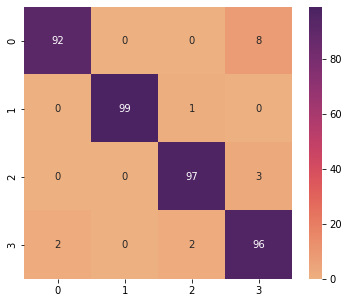

In [47]:
cf = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cf, cmap="flare", annot=True)

In [48]:
model.evaluate(test_imagegen_pca32)

13/13 [==============================] - 6s 421ms/step - loss: 0.1388 - accuracy: 0.9475


[0.1387503743171692, 0.9474999904632568]

###EfficientNet

In [50]:
base_model = EfficientNetV2B0(include_top=False, weights="imagenet")

base_model.trainable = False

inputs = Input(shape=(224,224,3))
 
x = base_model(inputs)

x = GlobalAveragePooling2D()(x)

x = Dropout(0.2)(x)

outputs = Dense(4, activation="softmax")(x)

model_en = Model(inputs, outputs)

model_en.compile(loss="categorical_crossentropy",
                optimizer=Adam(learning_rate=1e-2),
                metrics=["accuracy"])


model_en.fit(train_imagegen_pca32,
             epochs=20,
             steps_per_epoch = len(train_imagegen_pca32),
             validation_data = test_imagegen_pca32,
             validation_steps = int(0.25*len(test_imagegen_pca32)),
             callbacks=[my_callback])

24289280/24274472 [==============================] - 0s 0us/step
Epoch 1/20
38/38 [==============================] - 74s 2s/step - loss: 1.6101 - accuracy: 0.2533 - val_loss: 1.3726 - val_accuracy: 0.0000e+00
Epoch 2/20
38/38 [==============================] - 72s 2s/step - loss: 1.5037 - accuracy: 0.2767 - val_loss: 2.1261 - val_accuracy: 0.0000e+00
Epoch 3/20
38/38 [==============================] - 76s 2s/step - loss: 1.4487 - accuracy: 0.2808 - val_loss: 2.3152 - val_accuracy: 0.0000e+00
Epoch 4/20
38/38 [==============================] - 77s 2s/step - loss: 1.5045 - accuracy: 0.2775 - val_loss: 1.6671 - val_accuracy: 0.0000e+00
Epoch 5/20
38/38 [==============================] - 67s 2s/step - loss: 1.4522 - accuracy: 0.3008 - val_loss: 0.6113 - val_accuracy: 1.0000
Epoch 6/20
38/38 [==============================] - 72s 2s/step - loss: 1.3739 - accuracy: 0.3367 - val_loss: 0.6205 - val_accuracy: 1.0000
Epoch 7/20
38/38 [==============================] - 66s 2s/step - loss: 1.3760 

**The accuracy after 20 epochs is very low, so one can retrain the model with seting top 20 layers trainable while leaving `BatchNormalization` layers untrainable.**

In [63]:
def unfreeze_model(model):
    # Unfreezing the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
    # #making sure that BatchNorm is frozen
    # model.bn_layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"])

In [64]:
#unfreeze_model(model_en)
model_en.fit(train_imagegen_pca32,
             epochs=30,
             steps_per_epoch = len(train_imagegen_pca32),
             validation_data = test_imagegen_pca32,
             validation_steps = int(0.25*len(test_imagegen_pca32)),
             callbacks=[my_callback])

Epoch 1/30
38/38 [==============================] - 294s 8s/step - loss: 0.1226 - accuracy: 0.9550 - val_loss: 0.0388 - val_accuracy: 1.0000


In [65]:
# predictions = np.argmax(model_en.predict_generator(test_imagegen_pca32), axis=-1)

In [ ]:
# print(classification_report(y_test, predictions))

**prediction needs preprocessing data!**

In [ ]:
# cf = confusion_matrix(y_test, predictions)
# plt.figure(figsize=(6, 5))
# sns.heatmap(cf, cmap="flare", annot=True)

In [69]:
model_en.evaluate(test_imagegen_pca32)

13/13 [==============================] - 34s 3s/step - loss: 1.7846 - accuracy: 0.5425


[1.7846096754074097, 0.5425000190734863]

13/13 [==============================] - 16s 1s/step - loss: 1.7846 - accuracy: 0.5425


[1.7846096754074097, 0.5425000190734863]

In [70]:
from tensorflow.keras.models import load_model
model_en.save('efficientnet_coffee_detector.h5')
# # model = load_model('....h5')
# hist_json_file = 'pca32_coffee_detector_history.json' 
# with open(hist_json_file, mode='w') as f:
#      pd.DataFrame(model.history.history).to_json(f)